In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm

In [2]:
import multiprocessing
#import ipyparallel as ipp

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

In [3]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2

file_name = 'output_files/Hydrogen.out'
output = OutputInterface(file_name)
Ip = -output.saved_orbitals[output.HOMO][0]
kappa = np.sqrt(2*Ip)

SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP)

### Let's test the E*r transition amplitude on hydrogen!

In [4]:
n_r = 30
r_lst = np.linspace(1, 6, n_r)
flms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    flms.append(se.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(r, theta, phi), 30))

Evaluating at r=1.0000 	 Nr. 1/30
Evaluating at r=1.1724 	 Nr. 2/30
Evaluating at r=1.3448 	 Nr. 3/30
Evaluating at r=1.5172 	 Nr. 4/30
Evaluating at r=1.6897 	 Nr. 5/30
Evaluating at r=1.8621 	 Nr. 6/30
Evaluating at r=2.0345 	 Nr. 7/30
Evaluating at r=2.2069 	 Nr. 8/30
Evaluating at r=2.3793 	 Nr. 9/30
Evaluating at r=2.5517 	 Nr. 10/30
Evaluating at r=2.7241 	 Nr. 11/30
Evaluating at r=2.8966 	 Nr. 12/30
Evaluating at r=3.0690 	 Nr. 13/30
Evaluating at r=3.2414 	 Nr. 14/30
Evaluating at r=3.4138 	 Nr. 15/30
Evaluating at r=3.5862 	 Nr. 16/30
Evaluating at r=3.7586 	 Nr. 17/30
Evaluating at r=3.9310 	 Nr. 18/30
Evaluating at r=4.1034 	 Nr. 19/30
Evaluating at r=4.2759 	 Nr. 20/30
Evaluating at r=4.4483 	 Nr. 21/30
Evaluating at r=4.6207 	 Nr. 22/30
Evaluating at r=4.7931 	 Nr. 23/30
Evaluating at r=4.9655 	 Nr. 24/30
Evaluating at r=5.1379 	 Nr. 25/30
Evaluating at r=5.3103 	 Nr. 26/30
Evaluating at r=5.4828 	 Nr. 27/30
Evaluating at r=5.6552 	 Nr. 28/30
Evaluating at r=5.8276 	 Nr. 

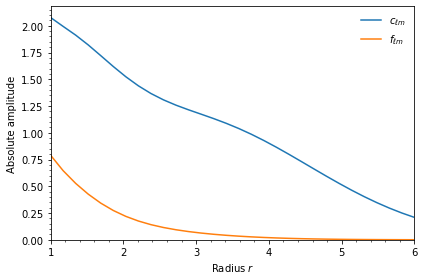

In [5]:
plt.figure(facecolor='white')

def radial(r, kappa):
    return r**(1/kappa - 1) * np.exp(-kappa*r)

def hyd_1s(r):
    return 1/np.sqrt(np.pi) * np.exp(-r)

sgn, l, m = 0,0,0
#plt.plot(r_lst, np.array([output.eval_orbital_spherical(r, np.pi/2, 0) for r in r_lst])*100, label=r'$\psi_0$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m])/radial(r_lst, kappa), label=r'$c_{\ell m}$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m]),  label=r'$f_{\ell m}$')
plt.legend(frameon=False)
plt.xlabel(r'Radius $r$')
plt.ylabel(r'Absolute amplitude')
plt.minorticks_on()
plt.xlim(r_lst[0], r_lst[-1])
plt.ylim(bottom=0)
plt.tight_layout()

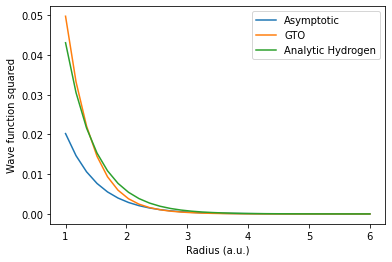

In [6]:
clm_array = se.get_as_coeffs(output.eval_orbital_spherical, 2.5, 30, Ip)

phi = 0
theta = 0

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array, Ip))**2, label='Asymptotic')
plt.plot(r_lst, np.abs(output.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
plt.plot(r_lst, np.abs(hyd_1s(r_lst))**2, label='Analytic Hydrogen')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

In [11]:
#dp = 4./250
#pzList = np.arange(-1.7, 1.7, dp)
#pxList = np.arange(0, 1.7, dp)

N = 30
pzList = np.linspace(-1.7, 1.7, 2*N)
pxList = np.linspace(0, 1.7, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

M_grid = np.array(pool.starmap(SP.M_asymp_xz_list, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))
#M_grid = np.array([SP.M_asymp_xz_list(px_list, py, pz_list, clm_array) for px_list, pz_list in zip(pxGrid, pzGrid)] )

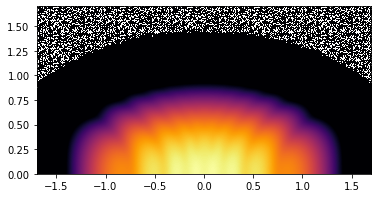

In [12]:
plt.figure(facecolor='white')

M2_grid = np.abs(M_grid)**2
MMax = np.max(M2_grid)

plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', norm=LogNorm(vmin=MMax*1e-6, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

### Should make a plot of the action alone..

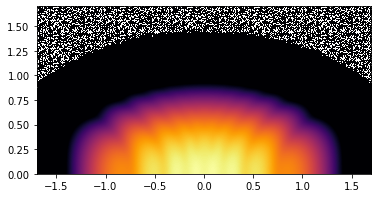

In [13]:
plt.figure(facecolor='white')

M_grid_S = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid)))  # The prefactor is just =1 here!
M2_grid_S = np.abs(M_grid)**2
MMax_S = np.max(M2_grid)

plt.imshow(np.flip(M2_grid_S,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', norm=LogNorm(vmin=MMax_S*1e-6, vmax=MMax_S),
           interpolation = 'bicubic', aspect = 1.)

### They look the same... Let's see if there is any difference.

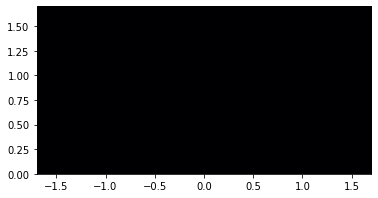

In [14]:
plt.imshow(np.flip(M2_grid - M2_grid_S,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', #norm=LogNorm(vmin=MMax_S*1e-6, vmax=MMax_S),
           interpolation = 'bicubic', aspect = 1.)

### That's not good...

### Let's try it for a molecule also.. Here we go with CHBrFCl

In [4]:
file_name = 'output_files/CHBrClF.out'
output = OutputInterface(file_name)
Ip = -output.saved_orbitals[output.HOMO][0]
kappa = np.sqrt(2*Ip)

SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp")

n_r = 30
r_lst = np.linspace(2, 13, n_r)

In [7]:
flms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    flms.append(se.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(r, theta, phi), 30))

Evaluating at r=2.0000 	 Nr. 1/30
Evaluating at r=2.3793 	 Nr. 2/30
Evaluating at r=2.7586 	 Nr. 3/30
Evaluating at r=3.1379 	 Nr. 4/30
Evaluating at r=3.5172 	 Nr. 5/30
Evaluating at r=3.8966 	 Nr. 6/30
Evaluating at r=4.2759 	 Nr. 7/30
Evaluating at r=4.6552 	 Nr. 8/30
Evaluating at r=5.0345 	 Nr. 9/30
Evaluating at r=5.4138 	 Nr. 10/30
Evaluating at r=5.7931 	 Nr. 11/30
Evaluating at r=6.1724 	 Nr. 12/30
Evaluating at r=6.5517 	 Nr. 13/30
Evaluating at r=6.9310 	 Nr. 14/30
Evaluating at r=7.3103 	 Nr. 15/30
Evaluating at r=7.6897 	 Nr. 16/30
Evaluating at r=8.0690 	 Nr. 17/30
Evaluating at r=8.4483 	 Nr. 18/30
Evaluating at r=8.8276 	 Nr. 19/30
Evaluating at r=9.2069 	 Nr. 20/30
Evaluating at r=9.5862 	 Nr. 21/30
Evaluating at r=9.9655 	 Nr. 22/30
Evaluating at r=10.3448 	 Nr. 23/30
Evaluating at r=10.7241 	 Nr. 24/30
Evaluating at r=11.1034 	 Nr. 25/30
Evaluating at r=11.4828 	 Nr. 26/30
Evaluating at r=11.8621 	 Nr. 27/30
Evaluating at r=12.2414 	 Nr. 28/30
Evaluating at r=12.6207

In [6]:
plt.figure(facecolor='white')

def radial(r, kappa):
    return r**(1/kappa - 1) * np.exp(-kappa*r)


sgn, l, m = 0,3,1
#plt.plot(r_lst, np.array([output.eval_orbital_spherical(r, np.pi/2, 0) for r in r_lst])*100, label=r'$\psi_0$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m])/radial(r_lst, kappa), label=r'$c_{\ell m}$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m]),  label=r'$f_{\ell m}$')
plt.legend(frameon=False)
plt.xlabel(r'Radius $r$')
plt.ylabel(r'Absolute amplitude')
plt.minorticks_on()
plt.xlim(r_lst[0], r_lst[-1])
plt.ylim(bottom=0)
plt.tight_layout()

NameError: name 'flms' is not defined

<Figure size 432x288 with 0 Axes>

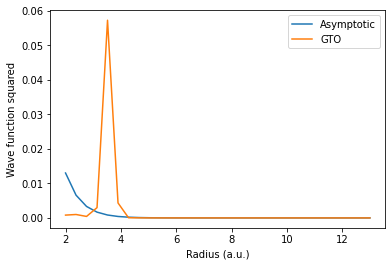

In [5]:
clm_array = se.get_as_coeffs(output.eval_orbital_spherical, 7, 50, Ip)

phi = 0
theta = 0

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array, Ip))**2, label='Asymptotic')
plt.plot(r_lst, np.abs(output.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

In [8]:
N = 30
pzList = np.linspace(-1.7, 1.7, 2*N)
pxList = np.linspace(0, 1.7, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

M_grid = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))
#M_grid = np.array(pool.starmap(SP.M_asymp_xz_list, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))

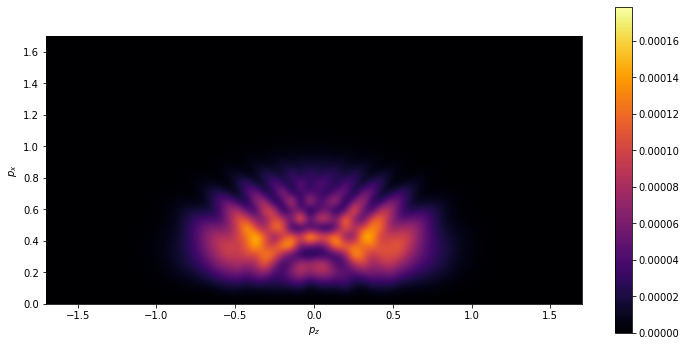

In [36]:
plt.figure(facecolor='white', figsize=(12,6))

M2_grid = np.abs(M_grid)**2
MMax = np.max(M2_grid)

plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', #norm=LogNorm(vmin=MMax*1e-6, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

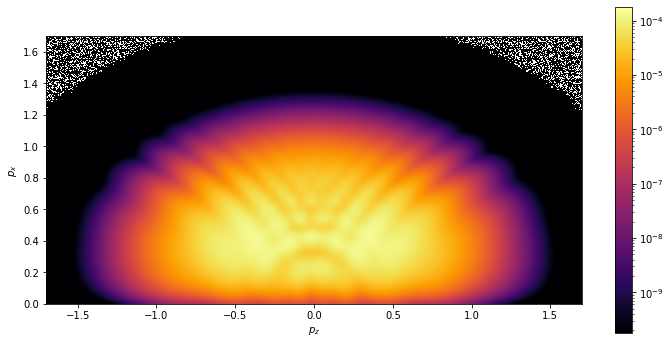

In [35]:
plt.figure(facecolor='white', figsize=(12,6))

M2_grid = np.abs(M_grid)**2
MMax = np.max(M2_grid)

plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', norm=LogNorm(vmin=MMax*1e-6, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

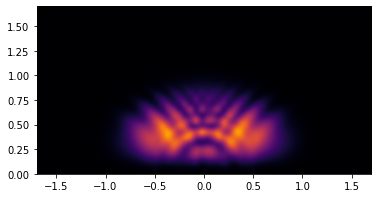

In [23]:
new_max = np.max(M2_grid - M2_grid_S)
plt.imshow(np.flip(M2_grid - M2_grid_S,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', #norm=LogNorm(vmin=new_max*1e-6, vmax=new_max),
           interpolation = 'bicubic', aspect = 1.)

### Let's try the OAM selection!

In [21]:
max_OAM = 4
OAM_list = np.arange(-max_OAM, max_OAM+1)

OAM_grids = []

N = 30
pzList = np.linspace(-1., 1., 2*N)
pxList = np.linspace(0, 1., N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

for OAM in OAM_list:
    print(f'Calculating for OAM : {OAM}')
    SP.OAM = int(OAM)
    OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))))

Calculating for OAM : -4
Calculating for OAM : -3
Calculating for OAM : -2
Calculating for OAM : -1
Calculating for OAM : 0
Calculating for OAM : 1
Calculating for OAM : 2
Calculating for OAM : 3
Calculating for OAM : 4


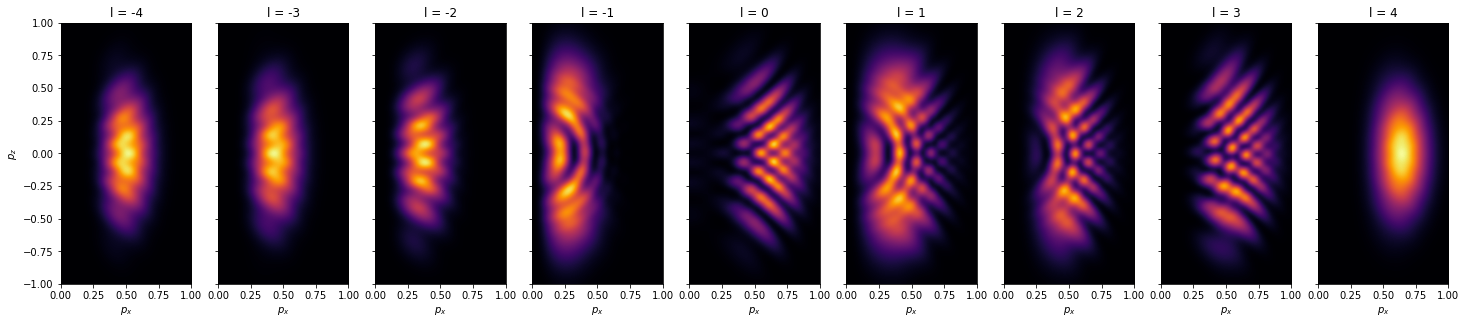

In [23]:
OAM2_grids = np.abs(OAM_grids)**2
Ml_max = np.max(OAM2_grids)

fig, axs = plt.subplots(1, len(OAM_list), sharey=True, figsize=(20,10), facecolor='white')
plt.tight_layout()
for i, Ml_grid in enumerate(OAM2_grids):
    axs[i].imshow(np.flip(Ml_grid.T,0) / Ml_max, cmap='inferno', aspect=1, interpolation = 'bicubic', #norm=LogNorm(vmin=Ml_max*1e-6, vmax=Ml_max),
                  extent = (np.amin(pxList), np.amax(pxList), np.amin(pzList), np.amax(pzList)))
    axs[i].set_title(f'l = {OAM_list[i]}')
    axs[i].set_xlabel('$p_x$')

axs[0].set_ylabel('$p_z$')

plt.savefig('Test.pdf')

In [15]:
print(clm_array[0,3,2])
print(clm_array[1,3,2])

(-0.39109064592788084-0.7503171012538191j)
(-0.39109064592788084+0.7503171012538192j)


In [16]:
print(clm_array[0,3,1])
print(clm_array[1,3,1])

(2.0198561421741283-3.6374089669210212j)
(-2.019856142174128-3.6374089669210212j)


In [20]:
print(clm_array[0,4,2])
print(clm_array[1,4,2])

(0.23367555912309+0.302171769744782j)
(0.23367555912309-0.302171769744782j)


## Numerical vs. SPA
We first look at JUST the exponentiated action, that is, we set $d(p,t)=1$

In [3]:
omega = 0.057     # Frequency of light
Up = 0.44         # Ponderomotive potential
CEP = np.pi/2
Ip = 0.35

sfa = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, "None", 1000, 1, 1)

In [4]:
dp = 4./100
pzList = np.arange(-1.7, 1.7, dp)
pxList = np.arange(-1.5, 1.5, dp)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

M_grid = np.array(pool.starmap(sfa.Mxz_List, zip(pxGrid, repeat(py), pzGrid)))
print('Done!')

Done!


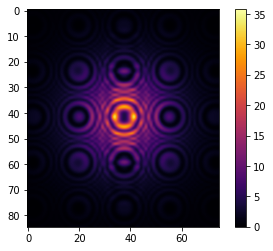

In [5]:
duh = np.flip(np.abs(M_grid.T), 0)**2
da_max = np.max(duh)
plt.figure(facecolor='white')
plt.imshow(duh, cmap='inferno', interpolation='bicubic')#, norm=LogNorm(vmin=da_max*1e-8, vmax=da_max))
plt.colorbar()
plt.show()

In [ ]:
print(np.max(M_grid))
